In [2]:
from flecs.trajectory import simulate_deterministic_trajectory
from flecs.utils import plot_trajectory, set_seed
from flecs.cell_population import CellPopulation, TestCellPop
import matplotlib.pyplot as plt
import torch
from torch.distributions.normal import Normal
from flecs.data.utils import load_interaction_data
from flecs.production import SimpleConv
import flecs.decay as dc

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap


class MyCellPop(CellPopulation):
    def __init__(self, n_cells: int = 1):
        """
        Cell Population which tracks the concentration of RNA and the concentration of 
        protein for each gene.

        Mechanisms are based on the calcium signaling pathway from KEGG:

        * 60 nodes and 57 edges.
        * 2 different types of nodes: ['compound', 'gene'].
        * 5 different types of interactions: ['', 'activation', 'binding/association', 
        'compound', 'inhibition'].

        Each edge type is associated with a graph convolution operation. Together 
        these graph convolutions are used to compute the production rates:

        For edges between genes, of type ("gene", *, "gene"),  messages are passed 
        from the source proteins to the target RNA. This aims at modeling 
        transcriptional regulation by Transcription Factor proteins with a separate
        protien state and gene state. Decay rates are exponential decays.

        Args:
            n_cells: Number of cells in the population.
        """
        interaction_graph = load_interaction_data("test")

        # Node state dim is [gene, protein].
        super().__init__(interaction_graph, n_cells=n_cells, per_node_state_dim=2)

        # Initialize additional node attributes.
        self["gene"].init_param(name="alpha", 
                                dist=Normal(5, 1), 
                                shape=(1, len(self["gene"]), 2)  # [gene, protein]
                                )
        self["gene"].init_param(name="translation_rates", 
                                dist=Normal(5, 1), 
                                shape=(1, len(self["gene"]), 1)
                                )
        self["compound"].init_param(name="alpha", 
                                    dist=Normal(5, 0.01), 
                                    shape=(1, len(self["compound"]), 2)  # [gene, protein]
                                    )

        # Initialize additional edge attributes.
        for e_type in self.edge_types:
            self[e_type].init_param(name="weights", dist=Normal(0, 1))
            self[e_type].simple_conv = SimpleConv(tgt_nodeset_len=len(self[e_type[2]]))

    def compute_production_rates(self):
        self.set_production_rates_to_zero()

        for e_type in self.edge_types:
            
            src_n_type, interaction_type, tgt_n_type = e_type
            if src_n_type == tgt_n_type == "gene":  # Gene-Gene edges.

                # RNA production depends on the concentration of parent proteins
                rna_prod_rates = self["gene"].production_rates[:, :, 0:1]
                protein_state = self["gene"].state[:, :, 1:2]

                rna_prod_rates += self[e_type].simple_conv(
                    x=protein_state,
                    edge_index=self[e_type].edges.T,
                    edge_weight=self[e_type].weights,
                )
            else:
                # Regular message passing
                self[tgt_n_type].production_rates += self[e_type].simple_conv(
                    x=self[src_n_type].state,
                    edge_index=self[e_type].edges.T,
                    edge_weight=self[e_type].weights,
                )

        # Protein production depends on the concentration of the RNA coding for that protein
        protein_prod_rates = self["gene"].production_rates[:, :, 1:2]
        protein_prod_rates += (
            self["gene"].translation_rates * self["gene"].state[:, :, 0:1]
        )

    def compute_decay_rates(self):
        for n_type in self.node_types:
            self[n_type].decay_rates = dc.exponential_decay(
                self, n_type, alpha=self[n_type].alpha
            )


# PCA visualization

+ 2 dimensions
+ each cell is a dot (different color)
+ show each cell every 10 secs 

/opt/python/38/envs/flecs/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


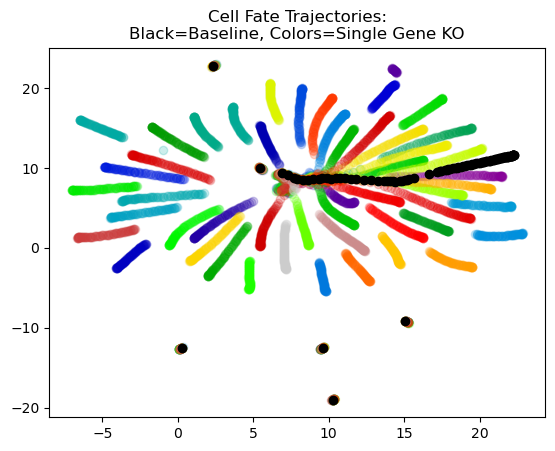

In [30]:
def calc_mse(X, mdl):
    """Resturns the mean squard error between the model reconstruction and input."""
    return np.mean(
        np.power(X - mdl.inverse_transform(mdl.transform(X)), [2])
    )


def fit_pca(X):
    scaler = StandardScaler().fit(X)  # unit variance, mean zero. 
    X = scaler.transform(X)  
    mdl = PCA(n_components=2)
    mdl.fit(X)

    return mdl, scaler


def fit_umap(X):
    scaler = StandardScaler().fit(X)  # unit variance, mean zero. 
    X = scaler.transform(X)  
    mdl = umap.UMAP(n_components=2)
    mdl.fit(X)

    return mdl, scaler


def embed(X, mdl, scaler):
    X = scaler.transform(X)
    z = mdl.transform(X)
    mse = calc_mse(X, mdl)

    return z, mse


def get_cell_pop(n_cells):
    set_seed(0)
    return MyCellPop(n_cells=n_cells)


def simulate_trajectories(cell_pop, n_steps):
    cell_traj = simulate_deterministic_trajectory(
        cell_pop, torch.linspace(0, 1, n_steps))
    #plot_trajectory(cell_traj[:, 0], legend=False)
    #plt.show()
    return cell_traj


def plot_perturbseq_experiments(n_steps=100, n_cells=10, method="umap"):


    methods = {
        "pca": fit_pca,
        "umap": fit_umap,
    }
    assert method in methods

    all_mse = []
    all_X = []

    # Collect a null sample from a healthy cell.
    cell_pop = get_cell_pop(n_cells)
    n_genes = cell_pop["gene"].basal_expression.shape[1]
    cell_traj = simulate_trajectories(cell_pop, n_steps)
    X = cell_traj[:, 0, :, 0]  # [n_timesteps, n_genes]
    all_X.append(X)

    # Do sequential gene knockouts (perturb-seq)
    for idx in range(n_genes):
        cell_pop = get_cell_pop(n_cells)

        # Perform the single-gene knockout.
        #cell_pop["gene"].state[:, idx, :] = 0
        cell_pop["gene"].basal_expression[:, idx, :] = 0
        cell_pop["gene"].alpha[:, idx, :] = 0
        cell_pop["gene"].translation_rates[:, idx, :] = 0
        
        # Collect trajectory from knocked-out cell.
        cell_traj = simulate_trajectories(cell_pop, n_steps)
        X = cell_traj[:, 0, :, 0]  # [n_timesteps, n_genes]
        all_X.append(X)

    all_X_concat = np.concatenate(all_X, axis=0)

    # Shared embedding space for all trajectories.
    mdl, scaler = methods[method](all_X_concat)

    # Plot each knockout experiment.
    cmap = plt.get_cmap('nipy_spectral')
    sliced_cm = cmap(np.linspace(0.1, 1, n_genes)) 

    for idx in range(n_genes):
        z, mse = embed(all_X[idx + 1], mdl, scaler)
        all_mse.append(mse)
        plt.scatter(z[:, 0], z[:, 1], color=sliced_cm[idx], alpha=0.2)

    # Use previously-fit model on baseline experiment.
    z, mse = embed(all_X[0], mdl, scaler)  
    all_mse.append(mse)
    plt.scatter(z[:, 0], z[:, 1], color="black")

    plt.title("Cell Fate Trajectories:\nBlack=Baseline, Colors=Single Gene KO")

plot_perturbseq_experiments(method="umap")

Text(0.5, 1.0, 'Cell Fate Trajectories: Black=Baseline, Colors=Single Gene KO')

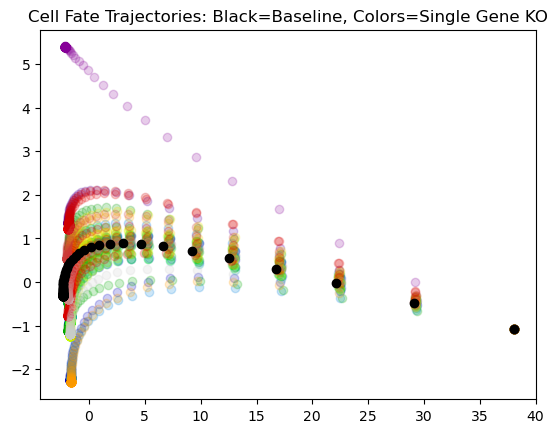

In [6]:
cell_pop["gene"]

NodeSet(idx_low=11, idx_high=60, node attributes: ['name', 'basal_expression', 'alpha', 'translation_rates'])

tensor([[[-0.],
         [-0.],
         [0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.],
         [0.],
         [0.]]])


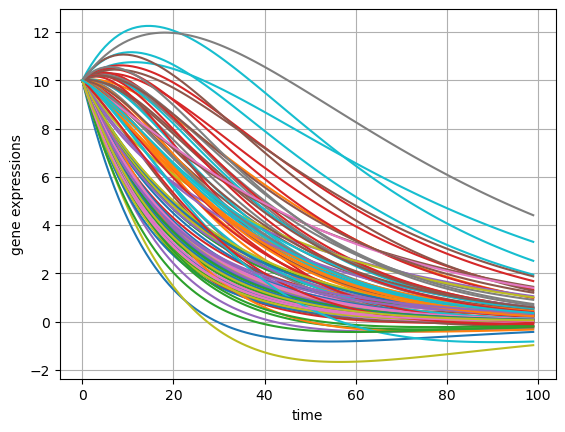

In [ ]:
def random_gene_gene_activation_intervention(p=0.5, a=100):

    set_seed(0)

    # Intervene on gene-gene activation pathways.
    cell_pop = MyCellPop()
    key = ('gene', 'activation', 'gene')
    dims = cell_pop[key].strength.shape
    mask = torch.FloatTensor(dims).uniform_() > p
    cell_pop[key].strength = cell_pop[key].strength * (mask * a)  # intervention.

    print(cell_pop[key].strength)
    print(cell_pop[key].__dict__)

    cell_traj = simulate_deterministic_trajectory(cell_pop, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj, legend=False)
    plt.show()

random_gene_gene_activation_intervention(p=0, a=1)
random_gene_gene_activation_intervention(p=0.5, a=10)
random_gene_gene_activation_intervention(p=0.5, a=0)